In [1]:
from __future__ import division
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.cross_validation import train_test_split
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import het_breushpagan
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
% matplotlib inline

### Combined Cycle Power Plant Data Set 

Features consist of hourly average ambient variables 
- Temperature (T) in the range 1.81°C and 37.11°C,
- Ambient Pressure (AP) in the range 992.89-1033.30 milibar,
- Relative Humidity (RH) in the range 25.56% to 100.16%
- Exhaust Vacuum (V) in teh range 25.36-81.56 cm Hg
- Net hourly electrical energy output (EP) 420.26-495.76 MW
The averages are taken from various sensors located around the plant that record the ambient variables every second. The variables are given without normalization.

Goals:

- Produce a professional quality regularized regression study of this data
- with a full study of feature selection, proper choice of regularization
- a full study (with graphs) of choice of the regularization parameter
- features selection for optimal bias-variance tradeoff
- Make sure to validate your model completely
- Choose the best parameters for the regression and provide a one paragraph explanation of all your choices. 

# **EDA**

In [5]:
# loading data
df = pd.read_csv('data/CCPP.csv')
df.head()

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


/Users/user/anaconda/lib/python2.7/site-packages/pandas/tools/plotting.py:2633: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.
  warnings.warn(msg, FutureWarning)


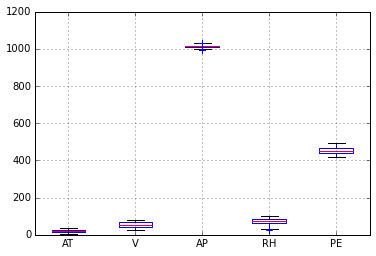

In [6]:
# boxplot to see what my data is like 
df.boxplot();

In [7]:
# getting an idea of what the mean, std, lower, upper quartiles are for each feature
df.describe()

,AT,V,AP,RH,PE
count,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000
mean,19.651231,54.305804,1013.259078,73.308978,454.365009
std,7.452473,12.707893,5.938784,14.600269,17.066995
min,1.810000,25.360000,992.890000,25.560000,420.260000
25%,13.510000,41.740000,1009.100000,63.327500,439.750000
50%,20.345000,52.080000,1012.940000,74.975000,451.550000
75%,25.720000,66.540000,1017.260000,84.830000,468.430000
max,37.110000,81.560000,1033.300000,100.160000,495.760000


/Users/user/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


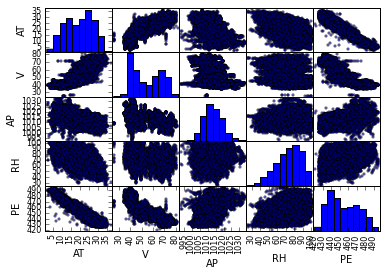

In [8]:
pd.scatter_matrix(df);

In [9]:
# There appears to be a strong relationship with Ambient Temperature and Exhaust Vacumm with predicted energy output PE

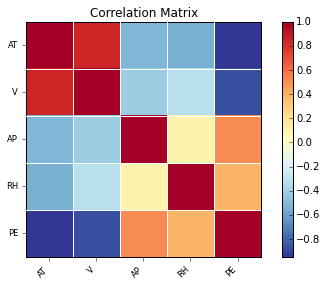

In [10]:
numerics_only = df.select_dtypes(['int64', 'float64'])
sm.graphics.plot_corr(numerics_only.corr(), xnames=numerics_only.columns.tolist())
plt.show()

In [11]:
# AT and VT seem highly correlated, they are probably strong correlating features for the regression model

# **DATA MODELING**

In [12]:
# using the full model and seeing how it predicts energy output

lm = smf.ols(formula='PE ~ AT + AP + RH + V', data=df).fit()
print lm.params

Intercept    454.609274
AT            -1.977513
AP             0.062083
RH            -0.158054
V             -0.233916
dtype: float64


In [13]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     PE   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                 3.114e+04
Date:                Wed, 20 Apr 2016   Prob (F-statistic):               0.00
Time:                        21:16:19   Log-Likelihood:                -28088.
No. Observations:                9568   AIC:                         5.619e+04
Df Residuals:                    9563   BIC:                         5.622e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    454.6093      9.749     46.634      0.000     435.500     473.718
AT            -1.9775      0.015   -129.342      0.000      -2.007      -1.948
AP             0.0621      0.009      6.564      0.000       0.044       0.081
RH            -0.1581      0.004    -37.918      0.000      -0.166      -0.150
V             -0.2339      0.007    -32.122      0.000      -0.248      -0.220
==============================================================================
Omnibus:                      892.002   Durbin-Watson:                   2.033
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4086.777
Skew:                          -0.352   Prob(JB):                         0.00
Kurtosis:                       6.123   Cond. No.                     2.13e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.13e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

-  R^2 value and adjusted R^2 value almost to 1
- small p value, std error, f-prob
- high f - stats, and t values
- this is indicates a strong statistically significant model

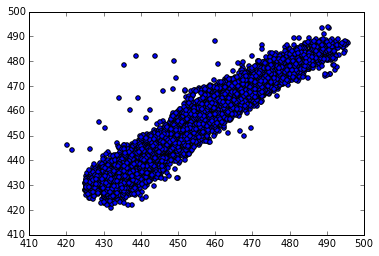

In [14]:
predicted = lm.predict()
plt.scatter(df['PE'],predicted);

- the full model is predicting the the values of the energy ouput well, but lets see if we can eliminate or reduce some features. 

In [15]:
X = np.asarray([df['AT'],df['V'],df['AP'],df['RH']]).T
y = np.asarray(df['PE'])

model = Lasso()

X_train , X_test, y_train, y_test = train_test_split(X,y)

model.fit(X_train,y_train)

predict = model.predict(X_test)

# using lasso, none of the features were reduced to 0.  

In [16]:
model.coef_ # using regularized regression, the coefficients are almost the same as the OLS model

array([-1.91894424, -0.25637873,  0.05441931, -0.14638369])

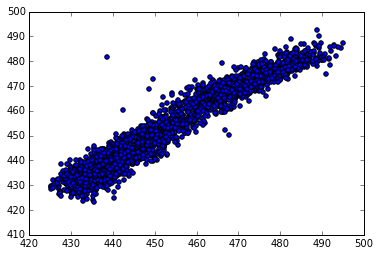

In [17]:
plt.scatter(y_test,predict); # not surprisingly, the predicted output is the same as well, which is close to the actual
# energy ouputs

# **Linearity Testing**

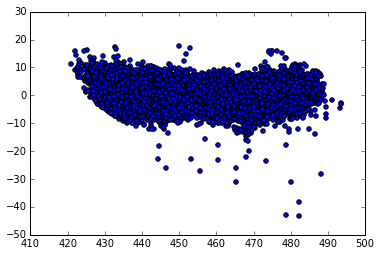

In [18]:
fitted = lm.fittedvalues
resid = lm.resid
plt.scatter(fitted,resid);
# data seems to be random 

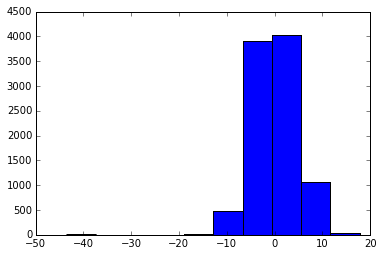

In [19]:
plt.hist(resid); # besides the bi on the far left, the data seems nearly normal

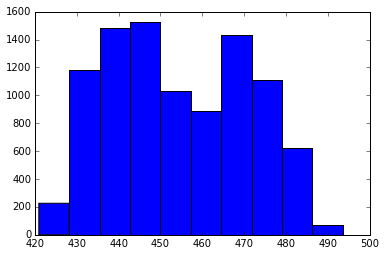

In [20]:
plt.hist(fitted); # fitted values seems to be normal as well

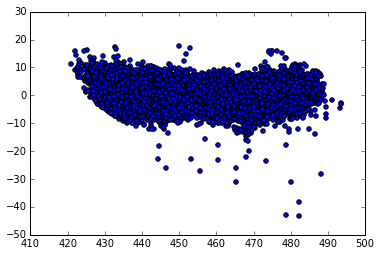

In [21]:
resid_pearson = lm.resid_pearson

plt.scatter(fitted, resid); # pearson residuals seem random as well 

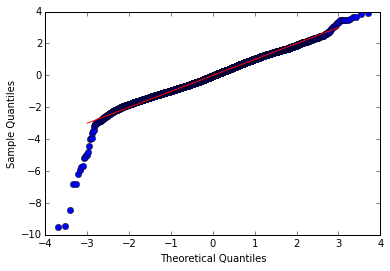

In [22]:
# Pearson Residuals appear to be following a linear trend.

qqplot(resid_pearson);
q = np.linspace(-3, 3)
plt.plot(q, q, color='r')
plt.show() # residuals nearly fit a straight line 

In [23]:
# model passes all linearity assumptions

# **FEATURE SELECTION**

In [24]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model

X = np.asarray([df['AT'],df['V'],df['AP'],df['RH']]).T

y = np.asarray(df['PE'])

###############################################################################
# Compute paths

n_alphas = 1000
alphas = np.logspace(-100,100 , n_alphas)
clf = linear_model.Ridge(fit_intercept=False)

coefs = []
for a in alphas:
    clf.set_params(alpha=a)
    clf.fit(X, y)
    coefs.append(clf.coef_)

Automatically created module for IPython interactive environment


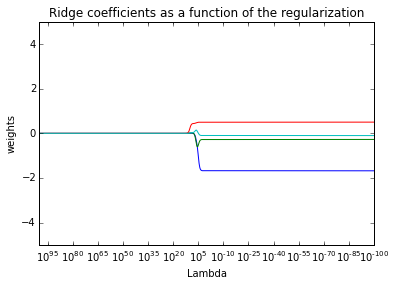

In [25]:
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])
plt.xlabel('Lambda')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.ylim(-5,5)
plt.show()

- as the size of  λ  increases, all the beta coefficients stay strong and survive.  So you can't take away any features yet.

In [26]:
from scipy import stats  
stats.f_oneway(df['AT'],df['V'],df['AP'],df['RH'],df['PE'])
#This is a significant model with a p value so small it is 0.

F_onewayResult(statistic=11383577.059911879, pvalue=0.0)

In [27]:
het_breushpagan(lm.resid, lm.model.exog)[1]
# lagrange multiplier test for heteroscedasticity.

7.701567364432115e-07

In [28]:
from sklearn.feature_selection import VarianceThreshold
X = np.asarray([df['AT'],df['V'],df['AP'],df['RH']]).T
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
sel.fit_transform(X)
# variance test, shows that since all the features are still left, then they all have low variance or STD error

array([[   14.96,    41.76,  1024.07,    73.17],
       [   25.18,    62.96,  1020.04,    59.08],
       [    5.11,    39.4 ,  1012.16,    92.14],
       ..., 
       [   31.32,    74.33,  1012.92,    36.48],
       [   24.48,    69.45,  1013.86,    62.39],
       [   21.6 ,    62.52,  1017.23,    67.87]])

In [29]:
from sklearn.feature_selection import SelectFromModel

X = np.asarray([df['AT'],df['V'],df['AP'],df['RH']]).T
y = np.asarray(df['PE']).T
print X.shape

lsvc = Lasso().fit(X, y)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X)
print X_new
# all the features are still there after using Lasso regression

(9568, 4)
[[   14.96    41.76  1024.07    73.17]
 [   25.18    62.96  1020.04    59.08]
 [    5.11    39.4   1012.16    92.14]
 ..., 
 [   31.32    74.33  1012.92    36.48]
 [   24.48    69.45  1013.86    62.39]
 [   21.6     62.52  1017.23    67.87]]


In [30]:
from sklearn.feature_selection import SelectFromModel

X = np.asarray([df['AT'],df['V'],df['AP'],df['RH']]).T
y = df['PE']

lsvc = ElasticNet().fit(X, y)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X)
print X_new
# only 1 feature stayed after elastic NET

[[ 14.96]
 [ 25.18]
 [  5.11]
 ..., 
 [ 31.32]
 [ 24.48]
 [ 21.6 ]]


In [31]:
from sklearn.feature_selection import SelectFromModel

X = np.asarray([df['AT'],df['V'],df['AP'],df['RH']]).T
y = df['PE']

lsvc = Ridge().fit(X, y)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X)
print X_new
# only 1 feature stayed after Ridge

[[ 14.96]
 [ 25.18]
 [  5.11]
 ..., 
 [ 31.32]
 [ 24.48]
 [ 21.6 ]]


In [32]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

X = np.asarray([df['AT'],df['V'],df['AP'],df['RH']]).T
y = df['PE']

X_train , X_test, y_train, y_test = train_test_split(X,y)

clf = RandomForestRegressor()
clf = clf.fit(X, y)
model = SelectFromModel(clf, prefit=True)
X_new = model.transform(X)
X_new
# only 1 feature stayed after RF Regressor

array([[ 14.96],
       [ 25.18],
       [  5.11],
       ..., 
       [ 31.32],
       [ 24.48],
       [ 21.6 ]])

**Ambient temperature (AT) stays as the strongest feature no matter which model I used for feature selection.  Initially, all the features stayed strong in the analysis of variance test and Lasso.  With the full model, it is already a strong and significant model.  But, the results indicate that even Temperature by itself, it will predict well for the energy output **

# **Trying Out Different Combinations of the Models**

In [33]:
lm = smf.ols(formula='PE ~ AT', data=df).fit()

In [34]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     PE   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                 8.510e+04
Date:                Wed, 20 Apr 2016   Prob (F-statistic):               0.00
Time:                        21:16:24   Log-Likelihood:                -29756.
No. Observations:                9568   AIC:                         5.952e+04
Df Residuals:                    9566   BIC:                         5.953e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    497.0341      0.156   3177.280      0.000     496.727     497.341
AT            -2.1713      0.007   -291.715      0.000      -2.186      -2.157
==============================================================================
Omnibus:                      417.457   Durbin-Watson:                   2.033
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1117.844
Skew:                          -0.209   Prob(JB):                    1.83e-243
Kurtosis:                       4.621   Cond. No.                         59.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

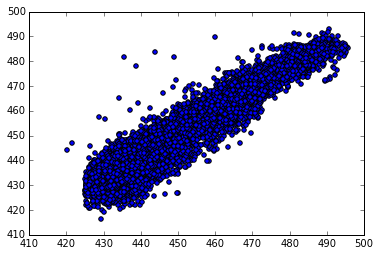

In [35]:
plt.scatter(df['PE'],lm.predict());

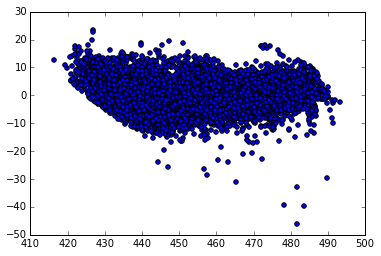

In [36]:
fitted = lm.fittedvalues
resid = lm.resid
plt.scatter(fitted,resid);

In [37]:
lm = smf.ols(formula='PE ~AP', data=df).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     PE   R-squared:                       0.269
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     3516.
Date:                Wed, 20 Apr 2016   Prob (F-statistic):               0.00
Time:                        21:16:24   Log-Likelihood:                -39224.
No. Observations:                9568   AIC:                         7.845e+04
Df Residuals:                    9566   BIC:                         7.847e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1055.2610     25.459    -41.449      0.000   -1105.167   -1005.355
AP             1.4899      0.025     59.296      0.000       1.441       1.539
==============================================================================
Omnibus:                      525.438   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              612.290
Skew:                           0.616   Prob(JB):                    1.10e-133
Kurtosis:                       2.859   Cond. No.                     1.73e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.73e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

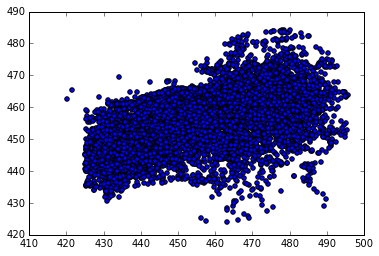

In [38]:
plt.scatter(df['PE'],lm.predict());

In [39]:
lm = smf.ols(formula='PE ~RH', data=df).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     PE   R-squared:                       0.152
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     1714.
Date:                Wed, 20 Apr 2016   Prob (F-statistic):               0.00
Time:                        21:16:25   Log-Likelihood:                -39933.
No. Observations:                9568   AIC:                         7.987e+04
Df Residuals:                    9566   BIC:                         7.988e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    420.9618      0.823    511.676      0.000     419.349     422.574
RH             0.4557      0.011     41.399      0.000       0.434       0.477
==============================================================================
Omnibus:                      772.278   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              319.245
Skew:                           0.231   Prob(JB):                     4.75e-70
Kurtosis:                       2.234   Cond. No.                         383.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

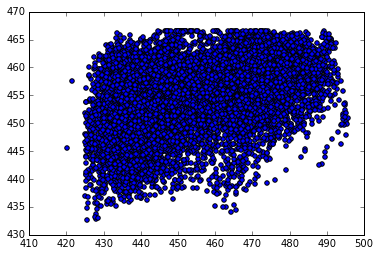

In [40]:
plt.scatter(df['PE'],lm.predict());

In [41]:
lm = smf.ols(formula='PE ~ RH + AP', data=df).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     PE   R-squared:                       0.384
Model:                            OLS   Adj. R-squared:                  0.384
Method:                 Least Squares   F-statistic:                     2985.
Date:                Wed, 20 Apr 2016   Prob (F-statistic):               0.00
Time:                        21:16:25   Log-Likelihood:                -38402.
No. Observations:                9568   AIC:                         7.681e+04
Df Residuals:                    9565   BIC:                         7.683e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -985.4949     23.422    -42.076      0.000   -1031.406    -939.584
RH             0.3993      0.009     42.359      0.000       0.381       0.418
AP             1.3921      0.023     60.077      0.000       1.347       1.438
==============================================================================
Omnibus:                      406.591   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              454.592
Skew:                           0.527   Prob(JB):                     1.93e-99
Kurtosis:                       2.830   Cond. No.                     1.74e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.74e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

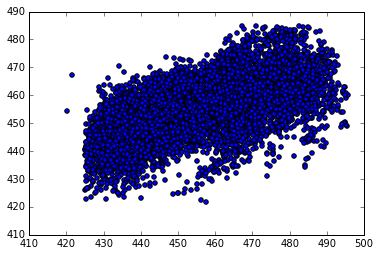

In [42]:
plt.scatter(df['PE'],lm.predict());

In [43]:
lm = smf.ols(formula='PE ~ V', data=df).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     PE   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                 2.972e+04
Date:                Wed, 20 Apr 2016   Prob (F-statistic):               0.00
Time:                        21:16:25   Log-Likelihood:                -33963.
No. Observations:                9568   AIC:                         6.793e+04
Df Residuals:                    9566   BIC:                         6.794e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    517.8015      0.378   1370.218      0.000     517.061     518.542
V             -1.1681      0.007   -172.402      0.000      -1.181      -1.155
==============================================================================
Omnibus:                       77.693   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              109.571
Skew:                          -0.097   Prob(JB):                     1.61e-24
Kurtosis:                       3.487   Cond. No.                         245.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

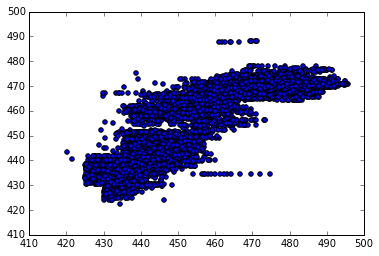

In [44]:
plt.scatter(df['PE'],lm.predict());

In [45]:
lm = smf.ols(formula='PE ~ AT + V', data=df).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     PE   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                 5.197e+04
Date:                Wed, 20 Apr 2016   Prob (F-statistic):               0.00
Time:                        21:16:26   Log-Likelihood:                -28887.
No. Observations:                9568   AIC:                         5.778e+04
Df Residuals:                    9565   BIC:                         5.780e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    505.4774      0.240   2101.855      0.000     505.006     505.949
AT            -1.7043      0.013   -134.429      0.000      -1.729      -1.679
V             -0.3245      0.007    -43.644      0.000      -0.339      -0.310
==============================================================================
Omnibus:                      526.355   Durbin-Watson:                   2.024
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1786.669
Skew:                          -0.198   Prob(JB):                         0.00
Kurtosis:                       5.080   Cond. No.                         282.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

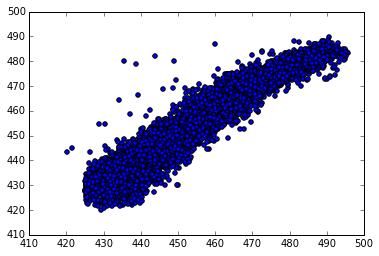

In [46]:
plt.scatter(df['PE'],lm.predict());

In [47]:
model2 = smf.ols(formula='PE ~ AT + V', data=df).fit()
model1 = smf.ols(formula='PE ~ AT + AP + RH + V', data=df).fit()
sm.stats.anova_lm(model1, model2)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,9563,198702.459591,0,NaN,NaN,NaN
1,9565,234836.592528,-2,-36134.132937,735.879741,NaN


In [48]:
X = np.asarray([df['AT'],df['V']]).T
y = np.asarray(df['PE'])

model = Ridge()

X_train , X_test, y_train, y_test = train_test_split(X,y)

model.fit(X_train,y_train)

predict = model.predict(X_test)

In [49]:
model.coef_

array([-1.71634121, -0.31773183])

In [50]:
model.intercept_

505.37768792854865

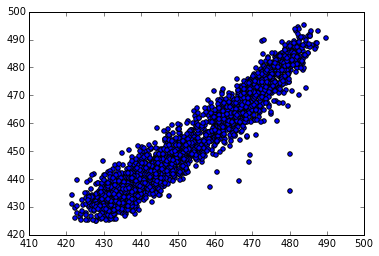

In [51]:
plt.scatter(predict,y_test);

# Final Model:

### cycle_power = 505.44-1.705x AT -0.324 x V

Although Ambient Temperature is strong enough as a predictor by itelf, I decided to leave next strongest coefficient exhaust vacumm (V) in there as well because it not only does it predict well by itself, it only slightly performs lower than Ambient Temperature.  Overall, the full model by itself is already a strong predictor, but if the model had to be reduced in any way, it would be this one.  Relative Humidity (RH) and Ambient Pressure (AP) did not do well as predictors by itself or with each other, only well if (AT) or (V) was added to the model.  

I chose to use Ridge regression because I liked that Ridge regression does not push small coefficients to 0.  Although I will lose interpretability, I will have a better predictive model in the long run if new features were introduced in the future because if the features are small, it will not be pushed to 0.  

This is model does not have too many parameters or complexity to overfit or else the model the data too closely.  It also has strong coefficients that can model the underlying trend and see new unseen data as well, with low bias and variance.  

# Validation

In [52]:
X = np.asarray([df['AT'],df['V']]).T
y = np.asarray(df['PE'])

from sklearn import cross_validation

ridge_cv = linear_model.RidgeCV(alphas=alphas)
k_fold = cross_validation.KFold(len(X), 3)

for k, (train, test) in enumerate(k_fold):
    ridge_cv.fit(X[train], y[train])
    print("[fold {0}] alpha: {1:.5f}, score: {2:.5f}".
          format(k, ridge_cv.alpha_, ridge_cv.score(X[test], y[test])))

[fold 0] alpha: 12.62121, score: 0.91509
[fold 1] alpha: 12.62121, score: 0.91680
[fold 2] alpha: 12.62121, score: 0.91522


**Not only is the score high, it is consistent, which means this is a strong predictive model for energy output ** 

In [53]:
ridge_cv = linear_model.Ridge(alpha=9.23)

model = ridge_cv.fit(X,y)

print model.coef_
print model.intercept_

[-1.70417264 -0.32453075]
505.478002966


**The changes were very small to the coefficients and intercept only by the decimal**

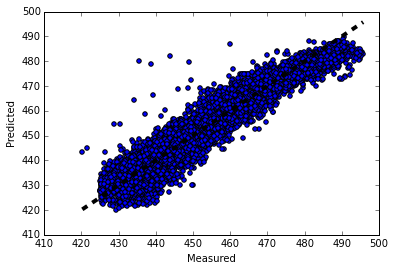

In [54]:
from sklearn import datasets
from sklearn.cross_validation import cross_val_predict
from sklearn import linear_model
import matplotlib.pyplot as plt

lr = linear_model.Ridge(alpha=9.23)

X = np.asarray([df['AT'],df['V']]).T
y = np.asarray(df['PE'])

# cross_val_predict returns an array of the same size as `y` where each entry
# is a prediction obtained by cross validated:
predicted = cross_val_predict(lr, X, y, cv=10)

fig, ax = plt.subplots()
ax.scatter(y, predicted)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

**The measured and predicted values are so close that it models the dotted regression line with very little variation.**

In [55]:
X = np.asarray([df['AT'],df['V']]).T
y = np.asarray(df['PE'])
ridge = linear_model.Ridge()
ridge.alpha = 9.23
cross_validation.cross_val_score(ridge, X, y, n_jobs=1)

array([ 0.91508958,  0.91679858,  0.91522399])

**Using cross val from sklearn, I was also able to consistently see high scores, demonstrating a strong predictive model**

# References:

Squid Plot:

http://scikit-learn.org/stable/auto_examples/linear_model/plot_ridge_path.html#example-linear-model-plot-ridge-path-py

Feature Selection:
    
http://scikit-learn.org/stable/modules/feature_selection.html


Model Selection:

http://scikit-learn.org/stable/model_selection.html

Predicting with Statsmodels:

http://statsmodels.sourceforge.net/devel/examples/notebooks/generated/predict.html

Regression Diagnostics:

http://statsmodels.sourceforge.net/devel/examples/notebooks/generated/regression_diagnostics.html

Cross Validation for Linear Models:

http://scikit-learn.org/stable/auto_examples/exercises/plot_cv_diabetes.html

Plotting Cross Validation:

http://scikit-learn.org/stable/auto_examples/plot_cv_predict.html#example-plot-cv-predict-py

Cross-validation: evaluating estimator performance

http://scikit-learn.org/stable/modules/cross_validation.html